# Problem 1. 

Use code discussed in class and presented in the attached Jupyter notebook apple_stock_prediction.ipynb. Choose another company and run the code for somewhat extended test days ending on November 2nd, 2023. If a company does not have a history going back to January 2016, use whatever data are available. 

# Time Series Analysis of `MSFT` stock values

For various manipulations we will need Numpy and will plot the results using matplotlib

In [1]:
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd  
%matplotlib inline 

In [2]:
import tensorflow as tf

In [3]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14402845962137347884
xla_global_id: -1
]


Downloaded data are loaded in a panda. Besides the date index, downloaded data have 6 features: Open,	High,	Low,	Close,	Adj Close, and	Volume.
    At the moment, we do not care about all of those features. We will look only at the opening price and ignore the others.

In [53]:
msft_training_complete = pd.read_csv(r'MSFT.csv')  

In [54]:
msft_training_complete.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1964,2023-10-23,325.470001,332.730011,324.390015,329.320007,329.320007,24374700
1965,2023-10-24,331.299988,331.839996,327.600006,330.529999,330.529999,31153600
1966,2023-10-25,345.019989,346.200012,337.619995,340.670013,340.670013,55053800
1967,2023-10-26,340.540009,341.630005,326.940002,327.890015,327.890015,37828500
1968,2023-10-27,330.429993,336.720001,328.399994,329.809998,329.809998,29835200


In [55]:
msft_training_complete['Date'] = pd.to_datetime(msft_training_complete['Date'])

In [56]:
filter = (msft_training_complete['Date'] > '2023-08-31')

In [57]:
msft_test = msft_training_complete[filter]

In [58]:
msft_test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
1929,2023-09-01,331.309998,331.989990,326.779999,328.660004,328.660004,14931200
1930,2023-09-05,329.000000,334.850006,328.660004,333.549988,333.549988,18553900
1931,2023-09-06,333.380005,334.459991,330.179993,332.880005,332.880005,17535800
1932,2023-09-07,331.290009,333.079987,329.029999,329.910004,329.910004,18381000
1933,2023-09-08,330.089996,336.160004,329.459991,334.269989,334.269989,19530100


In [59]:
filter1 = (msft_training_complete['Date'] <= '2023-08-31')

In [60]:
msft_training_complete = msft_training_complete[filter1]

In [61]:
msft_training_complete.to_csv('msft_train')
msft_test.to_csv('msft_test')

<Axes: xlabel='Date'>

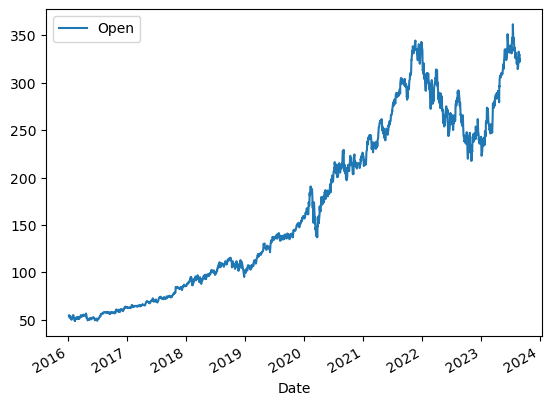

In [62]:
msft_training_complete.plot(x='Date',y='Open')

In [63]:
msft_training_processed = msft_training_complete.iloc[:, 1:2].values  

In [64]:
print(msft_training_processed)
print("length of the dataset: ", msft_training_processed.size)

[[ 54.32    ]
 [ 54.93    ]
 [ 54.32    ]
 ...
 [321.880005]
 [328.670013]
 [329.200012]]
length of the dataset:  1929


We want to normilize our data and will use SciKitLearn `MinMaxScaler` from sklearn.preprocessing libary. All values of `Open`(ing) price will be scaled to the interval between 0 and 1.

In [255]:
from sklearn.preprocessing import MinMaxScaler  
scaler = MinMaxScaler(feature_range = (0, 1))

msft_training_scaled = scaler.fit_transform(msft_training_processed)  


In a time series problem, we usually predict a value at time T, based on the data from the previous N time steps. In our case, we will predict `Open` price on day T, based on `Open` prices on days T-1,T-2,..., T-N. The number of steps (days), N, could be arbitray. Concretely, we will predict the opening stock price of the data based on the opening stock prices for the past 30 days. One presumes that larger N will give higher prediction. However, larger N will most probably result in longer training and possibly some loss of numerical precision. 

In [69]:
print(msft_training_scaled.shape)
print(msft_training_scaled)

(1929, 1)
[[0.01801514]
 [0.01996359]
 [0.01801514]
 ...
 [0.87264831]
 [0.89433677]
 [0.89602968]]


In the script below we create two lists: feature_set and labels. There are 1928 records in the training data. We execute a loop that starts from 61st record and stores 60 records at the beginning to the feature_set list. The 61st record is stored in the labels list. Then we move the cursor by one point and repeate the mapping. 

In [70]:
features_set = []  
labels = []  
for i in range(60, 1929):  
    features_set.append(msft_training_scaled[i-60:i,0])
    labels.append(msft_training_scaled[i,0])

In [71]:
print(len(features_set))
print(len(labels))
print(len(features_set[0]))
#print(features_set)
print(labels[0])

1869
1869
60
0.020027473089085507


We need to convert both the `feature_set` and the `labels list` to numpy arrays before we could use them for training. Execute the following code:

In [72]:
features_set, labels = np.array(features_set), np.array(labels)  

What are the dimensions of the feature set?

In [147]:
print(features_set.shape)
print(features_set.shape[0], features_set.shape[1])

(1869, 60, 1)
1869 60


In [74]:
print(labels.shape)
print(labels)

(1869,)
[0.02002747 0.02034688 0.02156067 ... 0.87264831 0.89433677 0.89602968]


## Convert Training Data to Right Shape
In order to train LSTM, we need to convert our data into the shape accepted by the LSTM. 
LSTM expects a three-dimensional format. 
The first dimension is the number of records or rows in the dataset which is 1868 in our case. 
The second dimension is the number of time steps which is 60.
The last dimension is the number of indicators. Since we are only using one feature, i.e Open, the number of indicators will be 1. Execute the following:

In [75]:
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))  

In [76]:
print(features_set.shape)

(1869, 60, 1)


## Traning the LSTM
We will use Keras API.  
The LSTM model we will create is sequential model with multiple layers. We will use four LSTM layers followed by a dense layer that predicts the future stock price.
Let's first import the libraries that we will need in order to create our model:

In [77]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense  
from tensorflow.keras.layers import LSTM  
from tensorflow.keras.layers import Dropout  

## Building the Model

As a first step, we need to instantiate the Sequential class. This is our model class. We will add LSTM, Dropout and Dense layers to this model. The first parameter to the LSTM layer is the number of neurons or nodes that we want in the layer. The second parameter is `return_sequences`, which is set to `True` since we will add more layers to the model. The first parameter to the `input_shape` is the number of time steps while the last parameter is the number of indicators.

`return_sequences`=`True`: `Boolean`. Whether to return the last output in the output sequence, or the full sequence. That return sequences return the hidden state output for each input time step. When stacking LSTM layers you must set `return_sequnce` to `True`
We are leaving 
`unroll=False`: `Boolean` (default `False`). If `True`, the network will be unrolled, else a symbolic loop will be used. Unrolling can speed-up a RNN, although it tends to be more memory-intensive. Unrolling is only suitable for short sequences.

In [78]:
model = Sequential()  
model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1),unroll=False))  

2023-10-30 15:05:16.481539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-30 15:05:16.482347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-30 15:05:16.482910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

To avoid over-fitting, we will add Dropout layers after every LSTM layer.

In [79]:
model.add(Dropout(0.2))  

In [80]:
model.add(LSTM(units=50, return_sequences=True))  
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))  
model.add(Dropout(0.2))

model.add(LSTM(units=50))  
model.add(Dropout(0.2))  


2023-10-30 15:05:18.932259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-30 15:05:18.932872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-30 15:05:18.933445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

The number of neurons, units = 50, in every LSTM subcell is somewhat arbitrary. You should play with that parameter and find an optimal value

## Creating a Dense Layer

To make our model more robust, we add a Dense layer at the end of the model. The number of neurons in the Dense layer will be set to 1 since we want to predict a single value in the output.


In [81]:
model.add(Dense(units = 1))  

In [82]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_5 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_6 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_6 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 50)               

## Model Compilation
Finally, we need to compile our LSTM model before we can train it on the training data. 

In [83]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')  

## Model Training
Now is the time to train the model that we defined in the previous few steps. To do so, we call the `fit` method on the model and pass it our training features and labels as shown below:


In [84]:
history = model.fit(features_set, labels, epochs = 100, batch_size = 32)  
model.save('msft.h5')

Epoch 1/100


2023-10-30 15:05:31.126272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-30 15:05:31.127152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-30 15:05:31.127573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

59/59 [==============================] - 4s 35ms/step - loss: 0.0199
Epoch 2/100
59/59 [==============================] - 2s 40ms/step - loss: 0.0039
Epoch 3/100
59/59 [==============================] - 2s 42ms/step - loss: 0.0035
Epoch 4/100
59/59 [==============================] - 2s 40ms/step - loss: 0.0036
Epoch 5/100
59/59 [==============================] - 2s 39ms/step - loss: 0.0029
Epoch 6/100
59/59 [==============================] - 2s 39ms/step - loss: 0.0032
Epoch 7/100
59/59 [==============================] - 2s 42ms/step - loss: 0.0028
Epoch 8/100
59/59 [==============================] - 2s 39ms/step - loss: 0.0030
Epoch 9/100
59/59 [==============================] - 2s 39ms/step - loss: 0.0032
Epoch 10/100
59/59 [==============================] - 2s 40ms/step - loss: 0.0026
Epoch 11/100
59/59 [==============================] - 2s 40ms/step - loss: 0.0034
Epoch 12/100
59/59 [==============================] - 2s 39ms/step - loss: 0.0024
Epoch 13/100
59/59 [=================

In [85]:
from tensorflow.keras.models import load_model
history_dict = history.history
history_dict.keys()

dict_keys(['loss'])

From the above, we see that our model history contains information only on the training loss. Had we had validation data passed to the training process we would have had validation loss and perhaps accuracy available as well.

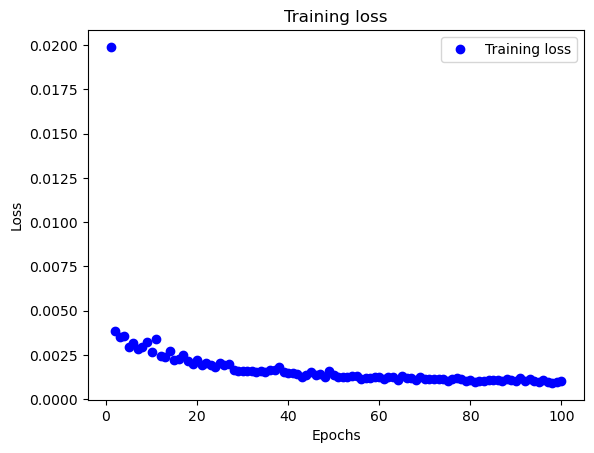

In [86]:
import matplotlib.pyplot as plt

loss = history.history['loss']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')

plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Testing our LSTM
We have successfully trained our LSTM, now we will test the performance of our network on the test set containing the opening stock prices for the month of September and a part of October 2023. 

As we did with the training data, we need to convert our test data to the right format. We first import our test data. The test data contain only prices for 34 days and has no overlap with the training data. 

Execute the following:


In [87]:
msft_testing_processed = msft_test.iloc[:, 1:2].values  
msft_testing_processed
print("Number of data points in test data: ", msft_testing_processed.size)

Number of data points in test data:  40


## Converting Test Data to Right Format

For each day in the test set, we want our feature set to contain the opening stock prices for the previous 60 days, what is almost 3 months. To do so, we need to concatenate our training data and test data before preprocessing. Execute the following:


In [88]:
msft_total = pd.concat((msft_training_complete['Open'], msft_test['Open']), axis=0)  

Now let's prepare our test inputs. The input for each day should contain the opening stock prices for the previous 60 days. That means we need opening stock prices for the 34 test days and stock prices from the last 60 days from the training set. Execute the following code to fetch those 94 values.

In [90]:
test_inputs = msft_total[len(msft_total) - len(msft_test) - 60:].values  

In [91]:
print(test_inputs.shape)
print(len(test_inputs))
print(test_inputs)

(100,)
100
[331.649994 323.940002 324.98999  328.579987 334.470001 334.339996
 337.480011 351.320007 339.309998 336.369995 334.119995 334.359985
 333.720001 331.859985 334.660004 334.709991 337.75     339.190002
 335.089996 337.299988 339.320007 334.600006 331.059998 336.600006
 339.559998 347.589996 345.679993 345.829987 361.75     353.570007
 349.149994 345.850006 347.109985 341.440002 340.480011 333.670013
 336.920013 335.190002 333.630005 326.       331.880005 328.369995
 326.959991 326.470001 326.019989 320.26001  321.390015 323.
 320.799988 320.540009 314.48999  317.929993 325.5      323.820007
 332.850006 321.470001 325.660004 321.880005 328.670013 329.200012
 331.309998 329.       333.380005 331.290009 330.089996 337.23999
 335.820007 331.309998 339.149994 336.920013 327.799988 326.170013
 329.51001  319.26001  321.320007 316.589996 315.130005 312.299988
 310.98999  317.75     316.279999 320.829987 314.029999 319.089996
 316.549988 324.75     330.959991 331.209991 330.570007 33

As we did for the training set, we need to scale our test data. We will use already defined `scalar` object. Execute the following:

In [92]:
test_inputs = test_inputs.reshape(-1,1)  
print(test_inputs.shape)
test_inputs = scaler.transform(test_inputs)  
print(test_inputs)

(100, 1)
[[0.90385535]
 [0.87922829]
 [0.88258214]
 [0.89404921]
 [0.91286294]
 [0.91244768]
 [0.92247744]
 [0.96668479]
 [0.92832273]
 [0.91893185]
 [0.91174496]
 [0.91251153]
 [0.91046731]
 [0.9045261 ]
 [0.91346984]
 [0.91362951]
 [0.92333983]
 [0.92793944]
 [0.91484331]
 [0.92190241]
 [0.9283547 ]
 [0.9132782 ]
 [0.9019708 ]
 [0.91966655]
 [0.92912128]
 [0.95477049]
 [0.9486696 ]
 [0.94914871]
 [1.        ]
 [0.97387168]
 [0.95975339]
 [0.94921266]
 [0.95323725]
 [0.93512634]
 [0.93205996]
 [0.91030764]
 [0.92068871]
 [0.91516275]
 [0.91017985]
 [0.88580829]
 [0.90459004]
 [0.89337846]
 [0.88887466]
 [0.88730955]
 [0.88587213]
 [0.86747376]
 [0.87108319]
 [0.87622576]
 [0.86919854]
 [0.86836813]
 [0.84904331]
 [0.86003128]
 [0.8842112 ]
 [0.87884501]
 [0.9076884 ]
 [0.87133868]
 [0.88472228]
 [0.87264831]
 [0.89433677]
 [0.89602968]
 [0.90276934]
 [0.89539081]
 [0.9093813 ]
 [0.90270549]
 [0.89887244]
 [0.92171077]
 [0.9171751 ]
 [0.90276934]
 [0.92781165]
 [0.92068871]
 [0.8915577

We scaled our data, now let's prepare our final test input set that will contain previous 60 stock prices from the training_set. Execute the following:

In [93]:
test_features = []  
for i in range(60, 94):  
    test_features.append(test_inputs[i-60:i, 0])


Finally, we need to convert our data into the three-dimensional format which can be used as input to the LSTM. Execute the following code

In [94]:
test_features = np.array(test_features)  
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))  
print(test_features.shape)

(34, 60, 1)


In [103]:
test_features

array([[[0.90385535],
        [0.87922829],
        [0.88258214],
        ...,
        [0.87264831],
        [0.89433677],
        [0.89602968]],

       [[0.87922829],
        [0.88258214],
        [0.89404921],
        ...,
        [0.89433677],
        [0.89602968],
        [0.90276934]],

       [[0.88258214],
        [0.89404921],
        [0.91286294],
        ...,
        [0.89602968],
        [0.90276934],
        [0.89539081]],

       ...,

       [[0.94921266],
        [0.95323725],
        [0.93512634],
        ...,
        [0.90040568],
        [0.90618713],
        [0.90193883]],

       [[0.95323725],
        [0.93512634],
        [0.93205996],
        ...,
        [0.90618713],
        [0.90193883],
        [0.89727536]],

       [[0.93512634],
        [0.93205996],
        [0.91030764],
        ...,
        [0.90193883],
        [0.89727536],
        [0.90653844]]])

## Making Predictions
We preprocessed our test data and now we can use it to make predictions. To do so, we simply need to call the `predict()` method on the model that we trained. Execute the following


In [95]:
predictions = model.predict(test_features)  

2023-10-30 15:22:35.810089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-30 15:22:35.810582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-30 15:22:35.811211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 7ms/step


Since we scaled our data, the predictions made by the LSTM are also scaled. We need to reverse the scaled prediction back to their actual values. To do so, we use the `ìnverse_transform` method of the `scaler` object we created during training. This is accomplished with the following: 

In [96]:
predictions = scaler.inverse_transform(predictions)  

Finally, let's see how well did our algorithm predicted the future stock prices. On the same diagram we will present original Open prices in the test data (blue) and predictions in red.

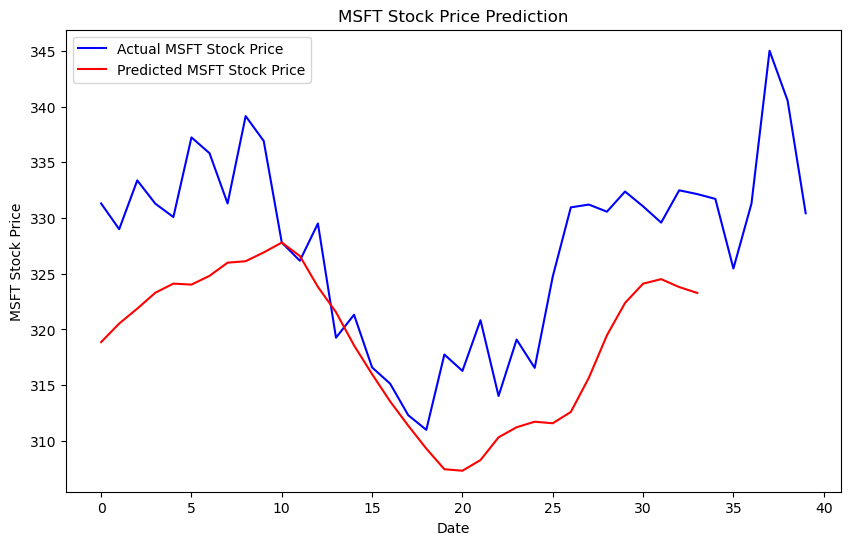

In [98]:
plt.figure(figsize=(10,6))  
plt.plot(msft_testing_processed, color='blue', label='Actual MSFT Stock Price')  
plt.plot(predictions , color='red', label='Predicted MSFT Stock Price')  
plt.title('MSFT Stock Price Prediction')  
plt.xlabel('Date')  
plt.ylabel('MSFT Stock Price')  
plt.legend()  
plt.show()  


# Problem 2. 

Start with the formulation in Problem 1 above. Modify your code so that instead of “manually” constructing train_features and test_features you use tf.keras.utils.timeseries_dataset_from_array(). That should make you code more robust and versatile. Usage of tf.keras.utils.timeseries_dataset_from_array() is illustrated at the end of the lecture notes an in the notebook: chapter10_dl-for-timeseries.ipynb. Demonstrate that you are getting the same results as in Problem 1.

In [236]:
#construct the training dataset
sampling_rate = 1
sequence_length = 60
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 1929

train_dataset = keras.utils.timeseries_dataset_from_array(
    msft_training_scaled,
    targets=msft_training_scaled,
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=1928)

In [253]:
#display training dataset output shapes
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (1869, 60, 1)
targets shape: (1869, 1)


In [153]:
# this is the identical result with what we obtained above by previous methods
print(features_set.shape)

(1869, 60, 1)


In [237]:
#construct the test dataset
sampling_rate = 1
sequence_length = 60
delay =  sampling_rate * (sequence_length + 24 - 1)
batch_size = 34

test_dataset = keras.utils.timeseries_dataset_from_array(
    test_inputs,
    targets=test_inputs,
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0)

In [251]:
#diplay test dataset output shapes
for samples, targets in test_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (34, 60, 1)
targets shape: (34, 1)


In [252]:
# this is the same result as we obtained above
print(test_features.shape)

(34, 60, 1)


In [239]:
#create model
model2 = Sequential()  
model2.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1),unroll=False))  
model2.add(Dropout(0.2))  
model2.add(LSTM(units=50, return_sequences=True))  
model2.add(Dropout(0.2))
model2.add(LSTM(units=50, return_sequences=True))  
model2.add(Dropout(0.2))
model2.add(LSTM(units=50))  
model2.add(Dropout(0.2))  
model2.add(Dense(units = 1))  


2023-11-04 10:14:14.739224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-04 10:14:14.739802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-04 10:14:14.740575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [240]:
model2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 60, 50)            10400     
                                                                 
 dropout_24 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_26 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_25 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_27 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_26 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_28 (LSTM)              (None, 50)               

In [241]:
model2.compile(optimizer = 'adam', loss = 'mean_squared_error')  

In [242]:
history2 = model2.fit(train_dataset, epochs = 100, batch_size = 32)  
model2.save('msft2.h5')

Epoch 1/100


2023-11-04 10:14:22.116697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-04 10:14:22.117637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-04 10:14:22.118108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 3s 3s/step - loss: 0.2141
Epoch 2/100
1/1 [==============================] - 1s 766ms/step - loss: 0.1703
Epoch 3/100
1/1 [==============================] - 1s 1s/step - loss: 0.1278
Epoch 4/100
1/1 [==============================] - 1s 895ms/step - loss: 0.0820
Epoch 5/100
1/1 [==============================] - 1s 1s/step - loss: 0.0387
Epoch 6/100
1/1 [==============================] - 1s 1s/step - loss: 0.0141
Epoch 7/100
1/1 [==============================] - 1s 947ms/step - loss: 0.0432
Epoch 8/100
1/1 [==============================] - 1s 945ms/step - loss: 0.0478
Epoch 9/100
1/1 [==============================] - 1s 1s/step - loss: 0.0263
Epoch 10/100
1/1 [==============================] - 1s 1s/step - loss: 0.0141
Epoch 11/100
1/1 [==============================] - 1s 1s/step - loss: 0.0149
Epoch 12/100
1/1 [==============================] - 1s 1s/step - loss: 0.0209
Epoch 13/100
1/1 [==============================] - 1s 1s/step - loss: 0.

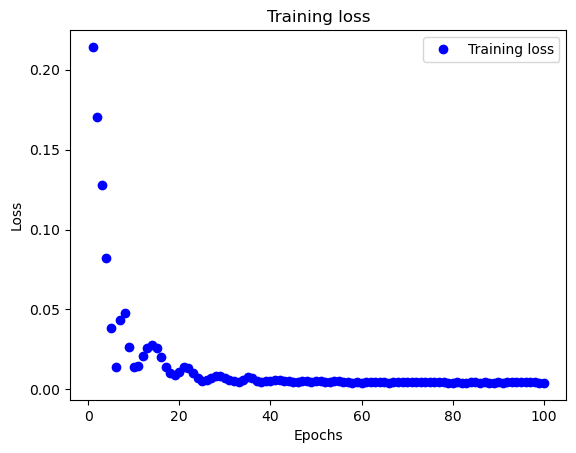

In [243]:
import matplotlib.pyplot as plt

loss = history2.history['loss']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')

plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [244]:
predictions2 = model2.predict(test_dataset)  

2023-11-04 10:18:03.109673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [41]
	 [[{{node Placeholder/_8}}]]
2023-11-04 10:18:03.110128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [100,1]
	 [[{{node Placeholder/_20}}]]
2023-11-04 10:18:03.230757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

2/2 [==============================] - 1s 9ms/step


In [256]:
predictions_inv2 = scaler.inverse_transform(predictions2) 

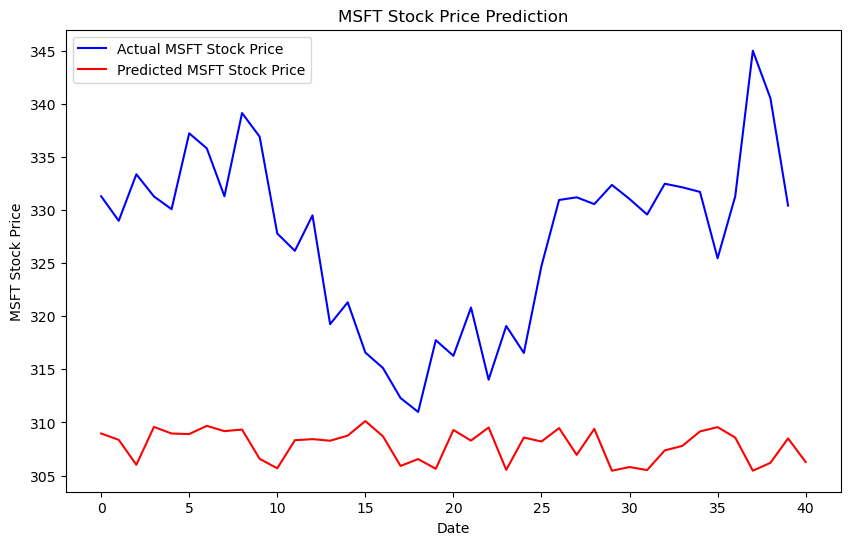

In [257]:
plt.figure(figsize=(10,6))  
plt.plot(msft_testing_processed, color='blue', label='Actual MSFT Stock Price')  
plt.plot(predictions_inv2 , color='red', label='Predicted MSFT Stock Price')  
plt.title('MSFT Stock Price Prediction')  
plt.xlabel('Date')  
plt.ylabel('MSFT Stock Price')  
plt.legend()  
plt.show()  

# Problem 3 

Let us treat the problem of stock price prediction as a “Multivariate Time Series Forecasting”. Rather than predicting the opening stock price on the 61st day based on 60 previous Open prices, as the elements of the input sequence use 5-dimensional vectors made of (Open, High, Low, Close, Volume). Keep the length of the input sequence to 60. Your label data still contain only the Open stock prices, and you are forecasting only the Open prices. Report on the loss behavior during the training process. Compare test results with those obtained in Problem 1.

In [263]:
#prepare training dataset by scaling original data with additional fields
scaler1 = MinMaxScaler(feature_range = (0, 1))
msft_train_processed = msft_training_complete.iloc[:, 1:].values  
msft_train_complete_scaled = scaler1.fit_transform(msft_train_processed)

In [264]:
msft_train_complete_scaled.shape

(1929, 6)

In [305]:
#construct the training dataset
sampling_rate = 1
sequence_length = 60
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 1929

train_dataset = keras.utils.timeseries_dataset_from_array(
    msft_train_complete_scaled,
    targets=msft_train_complete_scaled[:,1:2],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=1928)

In [306]:
#display training dataset output shapes
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (1869, 60, 6)
targets shape: (1869, 1)


2023-11-04 11:33:03.643524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-11-04 11:33:03.644515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [1928,1]
	 [[{{node Placeholder/_20}}]]


In [281]:
msft_testing_processed1 = msft_test.iloc[:, 1:].values  

In [288]:
msft_testing_scaled1 = scaler1.fit_transform(msft_testing_processed1)

In [267]:
#construct the test dataset
sampling_rate = 1
sequence_length = 60
delay =  sampling_rate * (sequence_length + 24 - 1)
batch_size = 34

test_dataset = keras.utils.timeseries_dataset_from_array(
    test_inputs,
    targets=test_inputs,
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0)

In [307]:
#construct the test dataset
sampling_rate = 1
sequence_length = 60
delay =  sampling_rate * (sequence_length + 24 - 1)
batch_size = 34

test_dataset1 = keras.utils.timeseries_dataset_from_array(
    msft_testing_scaled1,
    targets=msft_testing_scaled1[:,1:2],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0)

In [308]:
#diplay test dataset output shapes
for samples, targets in test_dataset1:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

2023-11-04 11:33:20.990004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [40,1]
	 [[{{node Placeholder/_20}}]]
2023-11-04 11:33:20.990878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [0]
	 [[{{node Placeholder/_8}}]]


In [269]:
for samples, targets in test_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (34, 60, 1)
targets shape: (34, 1)


In [270]:
model1 = Sequential()  
model1.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 6),unroll=False))  
model1.add(Dropout(0.2))  
model1.add(LSTM(units=50, return_sequences=True))  
model1.add(Dropout(0.2))
model1.add(LSTM(units=50, return_sequences=True))  
model1.add(Dropout(0.2))
model1.add(LSTM(units=50))  
model1.add(Dropout(0.2))  
model1.add(Dense(units = 1))  


2023-11-04 10:32:28.676842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-04 10:32:28.677774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-04 10:32:28.678672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [271]:
model1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_37 (LSTM)              (None, 60, 50)            11400     
                                                                 
 dropout_36 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_38 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_37 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_39 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_38 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_40 (LSTM)              (None, 50)              

In [272]:
model1.compile(optimizer = 'adam', loss = 'mean_squared_error')  

In [273]:
history1 = model1.fit(train_dataset, epochs = 100, batch_size = 32)  
model1.save('msft1.h5')

Epoch 1/100


2023-11-04 10:32:35.586473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-04 10:32:35.587406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-04 10:32:35.587889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 3s 3s/step - loss: 0.2588
Epoch 2/100
1/1 [==============================] - 1s 736ms/step - loss: 0.1673
Epoch 3/100
1/1 [==============================] - 1s 753ms/step - loss: 0.0982
Epoch 4/100
1/1 [==============================] - 1s 859ms/step - loss: 0.0426
Epoch 5/100
1/1 [==============================] - 1s 747ms/step - loss: 0.0133
Epoch 6/100
1/1 [==============================] - 1s 778ms/step - loss: 0.0358
Epoch 7/100
1/1 [==============================] - 1s 966ms/step - loss: 0.0478
Epoch 8/100
1/1 [==============================] - 1s 1s/step - loss: 0.0309
Epoch 9/100
1/1 [==============================] - 1s 959ms/step - loss: 0.0156
Epoch 10/100
1/1 [==============================] - 1s 883ms/step - loss: 0.0142
Epoch 11/100
1/1 [==============================] - 1s 812ms/step - loss: 0.0211
Epoch 12/100
1/1 [==============================] - 1s 885ms/step - loss: 0.0266
Epoch 13/100
1/1 [==============================] - 1s 

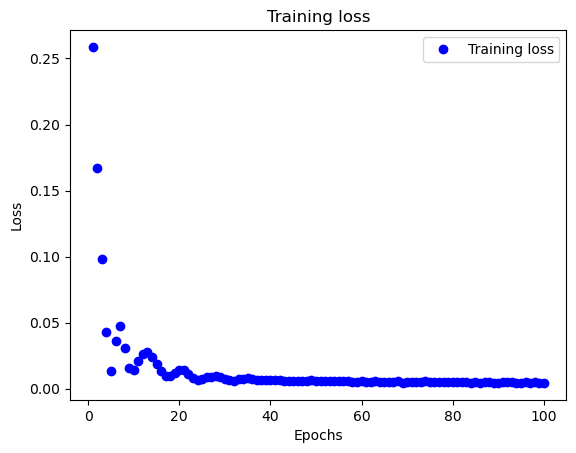

In [274]:
loss = history1.history['loss']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')

plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [223]:
Predictions1_like = np.zeros(shape=(len(predictions1), 6) )
Predictions1_like[:,0:1]=predictions1

In [226]:
predictions_inv = scaler1.inverse_transform(Predictions1_like)  

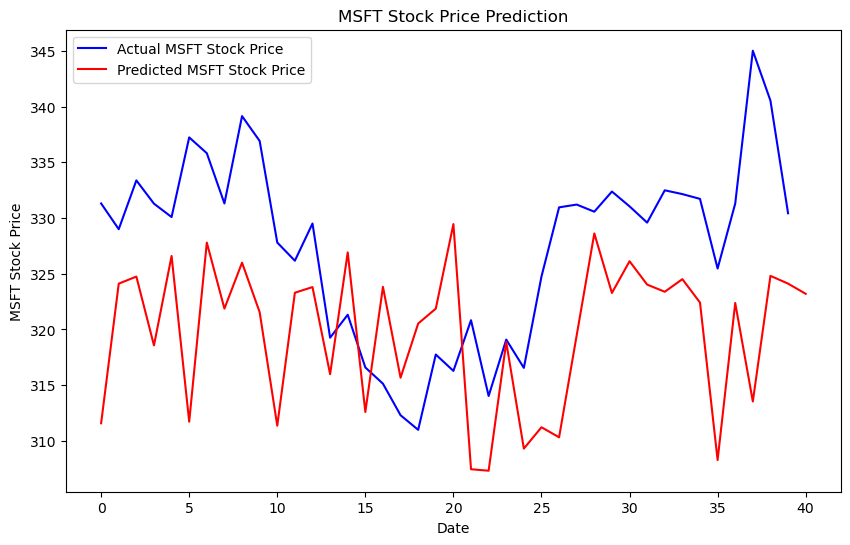

In [232]:
plt.figure(figsize=(10,6))  
plt.plot(msft_testing_processed, color='blue', label='Actual MSFT Stock Price')  
plt.plot(predictions_inv[:,0] , color='red', label='Predicted MSFT Stock Price')  
plt.title('MSFT Stock Price Prediction')  
plt.xlabel('Date')  
plt.ylabel('MSFT Stock Price')  
plt.legend()  
plt.show()  
